In [1]:
import pandas as pd
df = pd.read_csv(r'C:\Users\parul.kakade\Documents\NIFTY_Prediction\6.SVM\Data\merged_big.csv')
df.drop(columns=['Ticker_y', 'Ticker_x'], inplace=True)
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'SMA_14', 'EMA_14', 'RSI_14',
       'ATR_14', 'STOCH_K', 'STOCH_D', 'High_pct_change', 'Low_pct_change',
       'Close_pct_change', 'INDEX_FUTURES_Buy_Amount in Crore',
       'INDEX_FUTURES_Buy_No. of Contracts',
       'INDEX_FUTURES_OI_Amount in Crore', 'INDEX_FUTURES_OI_No. of Contracts',
       'INDEX_FUTURES_Sell_Amount in crore',
       'INDEX_FUTURES_Sell_No. of Contracts',
       'INDEX_OPTIONS_Buy_Amount in Crore',
       'INDEX_OPTIONS_Buy_No. of Contracts',
       'INDEX_OPTIONS_OI_Amount in Crore', 'INDEX_OPTIONS_OI_No. of Contracts',
       'INDEX_OPTIONS_Sell_Amount in crore',
       'INDEX_OPTIONS_Sell_No. of Contracts',
       'INTEREST_RATE_FUTURES_Buy_Amount in Crore',
       'INTEREST_RATE_FUTURES_Buy_No. of Contracts',
       'INTEREST_RATE_FUTURES_OI_Amount in Crore',
       'INTEREST_RATE_FUTURES_OI_No. of Contracts',
       'INTEREST_RATE_FUTURES_Sell_Amount in crore',
       'INTEREST_RATE_FUTURES_Sell_No. of Cont

In [2]:
import numpy as np
df['target'] = np.where(df['Close'] > df['Open'], 1, 0)
lagged_features = [col for col in df.columns if col not in ['Date', 'Open', 'Close', 'target']]
for lag in range(1, 4): 
    for col in lagged_features:
        df[f"{col}_lag{lag}"] = df[col].shift(lag)
df = df.dropna().reset_index(drop=True)
feature_cols = ['Open'] + [col for col in df.columns if col.endswith('_lag1')]
X = df[feature_cols].select_dtypes(include=[np.number])
y = df['target']


C:\Users\parul.kakade\AppData\Local\Temp\ipykernel_22212\4091701828.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{lag}"] = df[col].shift(lag)
C:\Users\parul.kakade\AppData\Local\Temp\ipykernel_22212\4091701828.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag{lag}"] = df[col].shift(lag)
C:\Users\parul.kakade\AppData\Local\Temp\ipykernel_22212\4091701828.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [3]:
print(X.isna().sum().sort_values(ascending=False).head())  
# X = X.fillna(0) 

Open           0
High_lag1      0
Low_lag1       0
SMA_14_lag1    0
EMA_14_lag1    0
dtype: int64


In [4]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', probability=True)) 
])

n_splits = 5  
cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

scores = cross_val_score(pipeline, X, y, cv=cv, scoring='accuracy')

print(f"{n_splits}-Fold CV Accuracy Scores: {scores}")
print(f"Mean CV Accuracy: {scores.mean():.4f}")


5-Fold CV Accuracy Scores: [0.55555556 0.64197531 0.59259259 0.58024691 0.59259259]
Mean CV Accuracy: 0.5926


In [5]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__gamma': ['scale', 0.01, 0.1, 1],
    'svm__kernel': ['rbf', 'poly']
}

grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid.fit(X, y)

print("Best Params:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Best Params: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}
Best CV Accuracy: 0.6024691358024692


In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, GridSearchCV
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
df = pd.read_csv(r'C:\Users\parul.kakade\Documents\NIFTY_Prediction\6.SVM\Data\merged_big.csv')
df.drop(columns=['Ticker_y', 'Ticker_x'], inplace=True)
df['target'] = (df['Close'] > df['Open']).astype(int)
feature_cols = df.columns.difference(['Date','Ticker_x','Ticker_y','Close','target'])
lagged_df = df[feature_cols].shift(1)
lagged_df['Open'] = df['Open']
lagged_df['target'] = df['target']
lagged_df.dropna(inplace=True)

X = lagged_df.drop(columns=['target']).select_dtypes(include=[np.number])
y = lagged_df['target']

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('svc', SVC())
])

param_grid = {
    'svc__C': [0.1, 1, 10],
    'svc__gamma': ['scale', 0.01, 0.1, 1],
    'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svc__degree': [2, 3, 4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(pipeline, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid.fit(X, y)

best_model = grid.best_estimator_
y_pred = cross_val_predict(best_model, X, y, cv=cv)

results_df = pd.DataFrame({'Actual': y.values, 'Predicted': y_pred}, index=y.index)

print("Best Params:", grid.best_params_)
print("Accuracy:", accuracy_score(y, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, target_names=['0','1']))


Best Params: {'svc__C': 10, 'svc__degree': 3, 'svc__gamma': 1, 'svc__kernel': 'poly'}
Accuracy: 0.5528756957328386
Confusion Matrix:
 [[152 138]
 [103 146]]
              precision    recall  f1-score   support

           0       0.60      0.52      0.56       290
           1       0.51      0.59      0.55       249

    accuracy                           0.55       539
   macro avg       0.56      0.56      0.55       539
weighted avg       0.56      0.55      0.55       539



In [5]:
results_df

,Actual,Predicted
2,0,0
3,0,0
4,0,0
5,1,1
6,0,0
...,...,...
628,1,0
629,1,0
631,0,0
632,1,1



📊 Distribution of Labels (Up vs Down):
           Count  Percentage
Direction                   
Down         426   60.339943
Up           280   39.660057


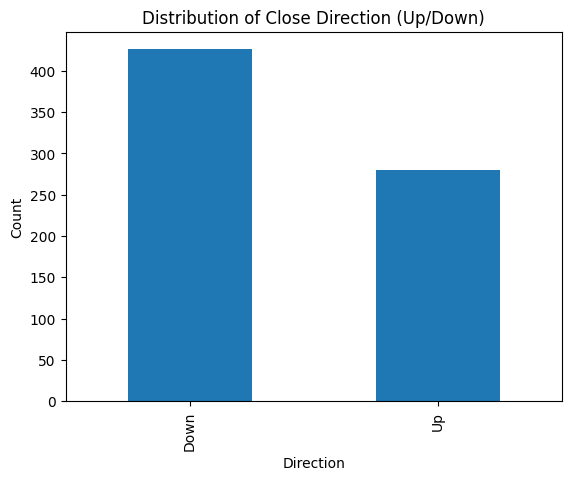


📈 Skewness of Numeric Features (sorted):
                                        Feature  Skewness
0   INTEREST_RATE_FUTURES_Sell_No. of Contracts  6.601794
1    INTEREST_RATE_FUTURES_Buy_No. of Contracts  6.599780
2     INTEREST_RATE_FUTURES_Buy_Amount in Crore  6.541582
3    INTEREST_RATE_FUTURES_Sell_Amount in crore  6.530522
4           INDEX_FUTURES_Sell_No. of Contracts  3.248281
5           STOCK_FUTURES_Sell_No. of Contracts  2.431922
6            STOCK_FUTURES_Buy_No. of Contracts  2.393448
7            STOCK_FUTURES_Sell_Amount in crore  2.242418
8            INDEX_FUTURES_Buy_No. of Contracts  2.230817
9             STOCK_FUTURES_Buy_Amount in Crore  2.214575
10           INDEX_FUTURES_Sell_Amount in crore  2.135224
11                                   SPX_Volume  1.790130
12                              High_pct_change  1.784488
13                                     VIX_High  1.688015
14            INDEX_FUTURES_Buy_Amount in Crore  1.670317
15     INTEREST_RATE_FUTURES_O

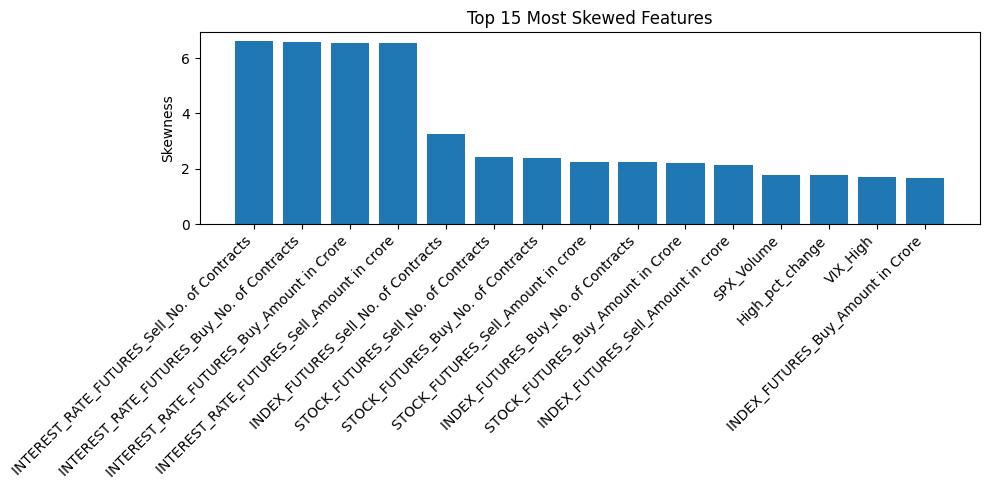

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_dataset_distribution_and_skewness(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    
    df['Direction'] = np.where(df['Close'] > df['Open'], 'Up', 'Down')
    
    label_counts = df['Direction'].value_counts()
    label_perc = df['Direction'].value_counts(normalize=True) * 100
    label_summary = pd.DataFrame({'Count': label_counts, 'Percentage': label_perc})
    
    print("\n📊 Distribution of Labels (Up vs Down):")
    print(label_summary)
    
    label_counts.plot(kind='bar')
    plt.title("Distribution of Close Direction (Up/Down)")
    plt.xlabel("Direction")
    plt.ylabel("Count")
    plt.show()
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    skewness = df[numeric_cols].skew().sort_values(ascending=False)
    
    skew_df = pd.DataFrame({'Feature': skewness.index, 'Skewness': skewness.values})
    print("\n📈 Skewness of Numeric Features (sorted):")
    print(skew_df)
    top_skewed = skew_df.head(15)
    plt.figure(figsize=(10, 5))
    plt.bar(top_skewed['Feature'], top_skewed['Skewness'])
    plt.title("Top 15 Most Skewed Features")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Skewness")
    plt.tight_layout()
    plt.show()
    
    return {'Label_Distribution': label_summary, 'Skewness': skew_df}

df = pd.read_csv(r'C:\Users\parul.kakade\Documents\NIFTY_Prediction\6.SVM\Data\merged_big_1.csv')
results = analyze_dataset_distribution_and_skewness(df)
